# A single-qubit universal classifier

###### Adrián Pérez-Salinas, Barcelona Supercomputing Center




In [232]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import itertools
from scipy.optimize import minimize

from functions_aux import *

In [233]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer import noise
IBMQ.load_account()

simulator='qasm_simulator'
quantum_device='ibmq_ourense'

/home/adrianps/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


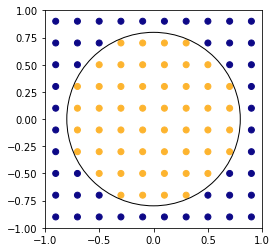

In [243]:
grid = 10
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X_train = np.asfarray(X)
Y_train = circle_labels(X_train)

fig = draw_circle((X_train, Y_train))

In [261]:
def measurement_circle(x, y, parameters, device, err_like_dev):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    if y == 1:
        C.x(1)
    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 4], 0)
        
    C.cswap(2, 0, 1)
    C.h(2)
    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    try:
        backend = Aer.get_backend(device)
        if err_like_dev != None:
            provider = IBMQ.get_provider()#hub='ibm-q')
            device = provider.get_backend(err_like_dev)
            properties = device.properties()
            coupling_map = device.configuration().coupling_map
            noise_model = noise.device.basic_device_noise_model(properties)
            basis_gates = noise_model.basis_gates
    except:
        provider = IBMQ.get_provider()#hub='ibm-q')
        backend=provider.get_backend(device)
        C=transpile(C, backend=backend)


    # Execute and get counts
    sh = 1024
    if err_like_dev!= None:
        result = execute(C, backend, shots=sh, noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
    else:
        result = execute(C, backend, shots=sh).result()
    
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity


def check_circle(x, parameters, device, err_like_device=None):
    Fidelities = np.zeros(2)
    fidelity = measurement_circle(x, 1, parameters, device, err_like_device)
    #for y in range(2):
        #Fidelities[y] = measurement_circle(x, y, parameters, device)
        
    return fidelity
    
    
def cost_function(parameters, Data, device, err_like_device=None):
    X = Data[0]
    Y = Data[1]
    chi2 = 0
    for x, y in zip(X, Y):
        chi2 += (1 - measurement_circle(x, y, parameters, device, err_like_device))**2
        
    return chi2 / len(Y)


In [257]:
layers=2
parameters = np.random.rand(5*layers)
solution2 = minimize(cost_function,parameters, args=((X_train, Y_train), simulator,'ibmq_vigo'), method='Powell')

solution2

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  

In [258]:
sol2=np.array([ 0.21726867,  2.38541401,  1.15276398,  1.48391773,  0.7626756 ,
        3.08470922, -0.75727229,  1.82653327,  6.93037407,  1.36189993]) #with errors


In [259]:
layers=2
optimal_parameters =sol2

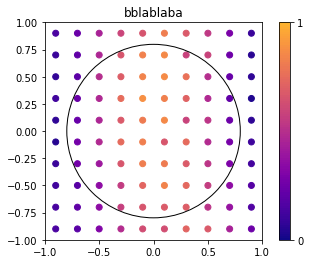

In [264]:
F_train = np.empty(len(X_train))
for i, x in enumerate(X_train):
    F_train[i]=check_circle(x, optimal_parameters, simulator, err_like_device='ibmq_vigo')

tit='bblablaba'
fig=draw_circle((X_train, F_train), colorbar=True, title = tit)


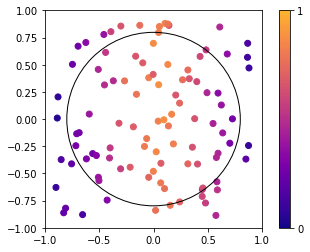

In [265]:
test=100
X_test = 1.8*np.random.rand(test, 2) - .9
Y_test = circle_labels(X_test)

F_test = np.empty(len(X_test))
for i, x in enumerate(X_test):
    F_test[i]=check_circle(x, optimal_parameters, simulator, err_like_device='ibmq_vigo')

fig=draw_circle((X_test, F_test), colorbar=True)

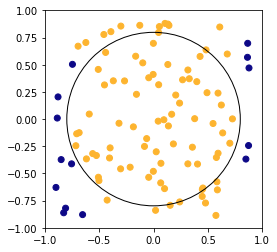

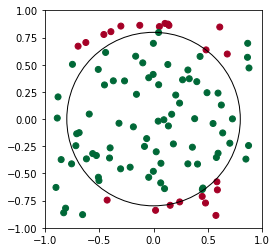

In [266]:
s_test, p_test = swipe_check(F_test, Y_test)

Z_test = (F_test > p_test).astype(int)
checks_test = (Z_test == Y_test).astype(int)
fig=draw_circle((X_test, Z_test), check=False)
fig=draw_circle((X_test, checks_test), check=True)

In [267]:
device = provider.get_backend('ibmq_vigo')
properties = device.properties()
coupling_map = device.configuration().coupling_map

In [227]:
coupling_map


[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

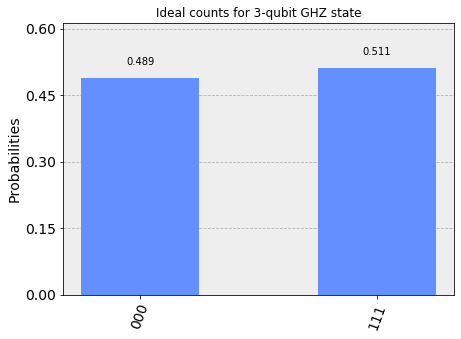

In [228]:


# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0,1,2], range(3))  # Can use list or generator like `range`.

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')



In [229]:
noise_model = noise.device.basic_device_noise_model(properties)

In [230]:
noise_model


NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'cx', 'id', 'u2', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]

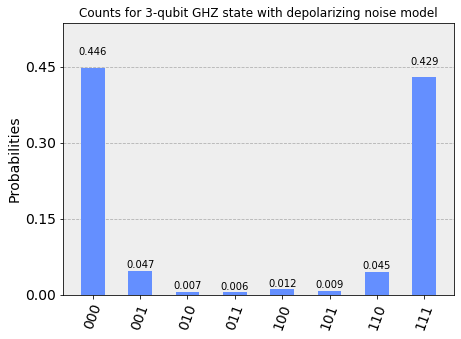

In [231]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(circ, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")